# Projeto Visão Computacional - Reconhecimento de Íris

### Lucas Chen Alba


Projeto com o objetivo de processar as imagens e treinar o modelo de reconhecimento de íris `Gate6 Iris Recognition` e avaliar como as diferentes técnicas de pré processamento afetam a qualidade do modelo treinado.

### Foram testadas as técnicas de pré processamento:
- Processamento morfológico: redução de detalhes
- Filtro Sobel: detecção de bordas
- Blur com kernel 3x3: suavização da imagem para redução de detalhes
- Sharpening: aumento de definição e detalhes
- Equalização de histograma: aumento de contraste
- Filtro 2D: retirada de detalhes (cílios)

### Baseado em testes, foram escolhidos diversas técnicas para serem aplicadas em conjunto
- Processamento morfológico + Blur: redução de detalhes com foco em remover os cílios
- Processamento morfológico + Equalização de histograma: remoção de cílios com contraste aumentado
- Processamento morfológico + Equalização de histograma + Blur: remoção de cílios com contraste aumentado e redução de detalhes

- Filtro 2D + Equalização de histograma: remoção de cílios com contraste aumentado
- Filtro 2D + Blur: redução de detalhes com foco em remover os cílios
- Filtro 2D + Equalização de histograma + Blur: remoção de cílios com contraste aumentado e redução de detalhes


#### Obs.: as imagens onde foi aplicada a equalização de histograma estão com uma cor verde, porém isso ocorre apenas na vizualização. Por este motivo as imagens são carregadas do disco após o processamento.

In [1]:
import G6_iris_recognition
import os
from matplotlib import pyplot as plt
import cv2
import pathlib
import numpy as np
import shutil
import contextlib
import sys


In [2]:
def process_images(proc_func, img_dir, proc_img_dir):
    '''
    Funtion to apply a certain processing to images
    '''
    # Create processed images directory if doesn't exist
    pathlib.Path(os.getcwd() + '/datasets/' + proc_img_dir).mkdir(parents=True, exist_ok=True)
    # Directory to read images from
    imgs_dir = os.getcwd() + '/datasets/' + img_dir
    for subdir in os.listdir(imgs_dir):
        full_subdir = imgs_dir + '/' + subdir
        for filename in os.listdir(full_subdir):
            if filename.endswith(".bmp"):
                image_name = os.path.join(full_subdir, filename).split('/', 7)[-1]
                curr_dir = os.path.join(imgs_dir, filename).rsplit('/', 2)[0] + '/' + proc_img_dir + '/' + subdir + '/'
                # Apply pre-processing
                processed = proc_func(image_name)
                # Save image
                pathlib.Path(curr_dir).mkdir(parents=True, exist_ok=True)
                cv2.imwrite(curr_dir + image_name.split('/')[-1], processed)
                # print(curr_dir + image_name.split('/')[-1])

            else:
                continue

In [3]:
def train_model(process_name):
    '''
        Function to train model
    '''
    # Create model file and directory if not exists
    pathlib.Path(os.getcwd() + '/models').mkdir(parents=True, exist_ok=True)
    f = open('models/' + process_name + '.pickle','w+')
    f.close()

    # Create results file and append training logs
    with open('results/' + process_name + '.txt', "w") as results:
        with contextlib.redirect_stdout(results):
            valid_iris = G6_iris_recognition.iris_model_train('datasets/' + process_name, 'models/' + process_name + '.pickle')
            print(valid_iris)

In [4]:
def removeEmptyFolders(path):
    '''
      Function to remove empty folders
    '''

    if (not os.path.isdir(path)):
        return

    # remove empty subfolders
    files = os.listdir(path)
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            if os.path.isdir(fullpath):
                # if folder empty, delete it
                files = os.listdir(fullpath)
                # Remove folder if contains less than 5 images
                if len(files) < 5:
                    # print ("Removing folder:", fullpath)
                    shutil.rmtree(fullpath)


In [5]:
def clean_dataset(process_name):
    '''
        Function to copy processed images
        and remove "bad" images from dataset
    '''
    # Make a copy of the original dataset
    clean_dataset_dir = 'datasets/' + process_name + '_clean'
    shutil.copytree('datasets/' + process_name, clean_dataset_dir)
    

    training_results = open('results/' + process_name + '.txt', 'r')
    lines = training_results.readlines()

    # Strips the newline character
    for i in range(len(lines)):
        # os.remove()
        line = lines[i].strip().split(' ')
        if (i < len(lines) - 1):
            next_line = lines[i + 1].strip().split(' ')
        # print(line)
        if (((line[0] == 'path_to_image') and (next_line[0] == 'locate')) or((line[0] == 'path_to_image') and (next_line[0] == 'rectangle'))):
            # Remove image from the clean dataset
            os.remove(clean_dataset_dir + '/' + line[-1].split('/', 2)[-1])
    
    removeEmptyFolders(clean_dataset_dir)


In [6]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [7]:
def test_images(process_name):
    '''
        Function to test images using trained model
    '''
    total_imgs = 0
    correct_imgs = 0
    positive_imgs = 0
    false_positives = 0
    
    if (process_name.rsplit('_', 1)[-1] == 'clean'):
        process_name_dataset = process_name
        process_name = process_name.rsplit('_', 1)[0]
    
    # Disable prints to avoid flooding
    with HiddenPrints():
        imgs_dir = os.getcwd() + '/datasets/' + process_name_dataset
        for subdir in os.listdir(imgs_dir):
            full_subdir = imgs_dir + '/' + subdir
            for filename in os.listdir(full_subdir):
                if filename.endswith(".bmp"):
                    image_name = os.path.join(full_subdir, filename).split('/', 7)[-1]
                    # print(image_name)
                    person_name = image_name.split('/')[-2]
                    result = G6_iris_recognition.iris_model_test('models/' + process_name + '_clean.pickle', image_name)
                    if (not result == 'unmatch'):
                        positive_imgs += 1
                        if (person_name == result):
                            correct_imgs += 1
                        else:
                            false_positives += 1
                    total_imgs += 1
                    # print('result:', result)
    # Restore prints
    print('Processing type:', process_name)
    print('Total tested images:', total_imgs)
    print('Total matched images:', positive_imgs, '(', positive_imgs/total_imgs * 100, '% )')
    print('Total correct images:', correct_imgs)
    print('Total false positives:', false_positives, '\n\n')

In [8]:
def morph_process(image_name):
    
    image = cv2.imread(image_name)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT , (2,2))
    bg = cv2.morphologyEx(image, cv2.MORPH_DILATE, kernel)
    gray_details = cv2.divide(image, bg, scale=255)
    morph_image = cv2.subtract(gray_details, image)
    morph_image = cv2.bitwise_not(morph_image)

    return morph_image


In [9]:
def sobel_process(image_name):
    '''
        Apply Sobel Edge detection on X and Y
    '''
    image = cv2.imread(image_name)
    sobelxy = cv2.Sobel(src=image, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)

    return sobelxy


In [10]:
def blur_process(image_name):
    image = cv2.imread(image_name)

    blur_3x3_image = cv2.GaussianBlur(image,(3,3), sigmaX=0, sigmaY=0)

    return blur_3x3_image


In [11]:
# Sharpen image
def sharp_process(image_name):
    image = cv2.imread(image_name)

    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharp_image = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)

    return sharp_image

In [12]:
# Equalize histogram

def hist_eq_process(image_name):
    image = cv2.imread(image_name)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist_eq_image = cv2.equalizeHist(gray_image)
    
    return hist_eq_image


In [13]:
# Filter 2D

def contour_process(image_name):
    image = cv2.imread(image_name)

    kernel = np.array((
        [1,  0, 1],
        [0, -4, 0],
        [1,  0, 1]), dtype="int")

    borders = cv2.filter2D(image, -1, kernel)
    borders = cv2.bitwise_not(borders)

    contour_image = cv2.subtract(borders, image)
    contour_image = cv2.bitwise_not(contour_image)
    
    return contour_image

In [14]:
# Gabor Filter
# Gabor filter com wavelet

In [15]:
image = cv2.imread('datasets/no_processing/0000/0000_001.bmp')

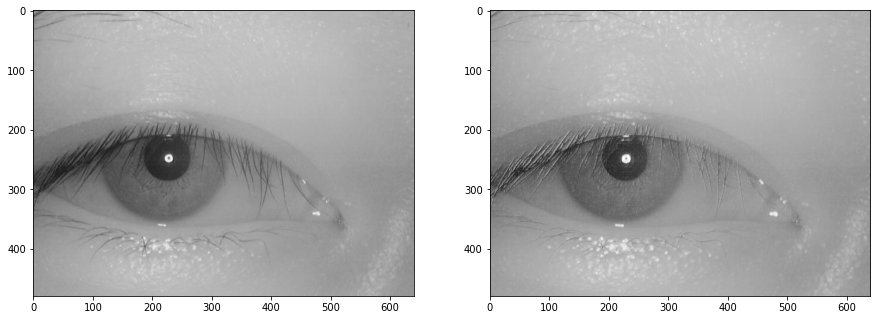

In [16]:
# Morph test
morph_image = morph_process('datasets/no_processing/0000/0000_001.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(morph_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


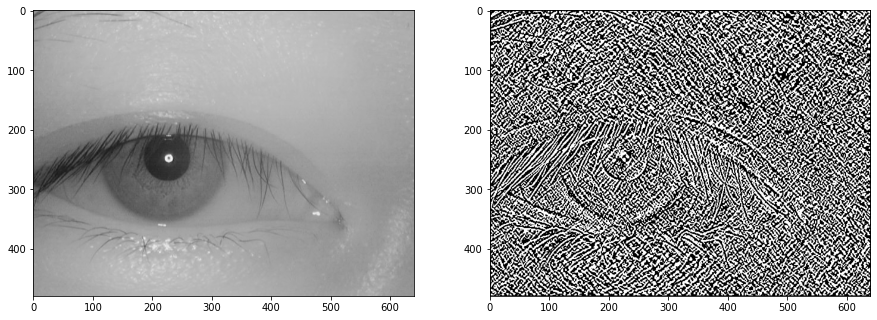

In [17]:
# Sobel test
sobel_image = sobel_process('datasets/no_processing/0000/0000_001.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(sobel_image)

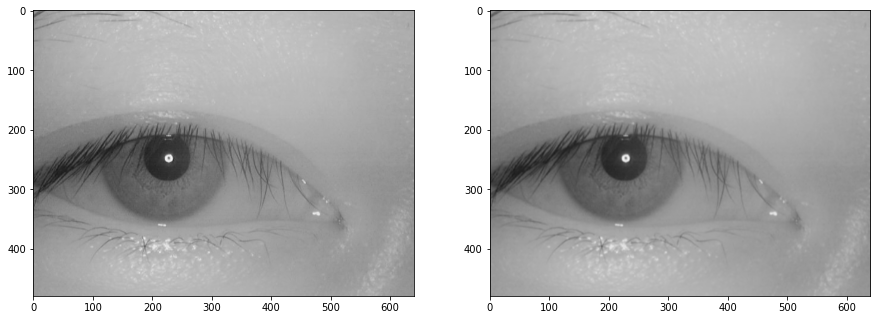

In [18]:
# Blur test
blur_3x3_image = blur_process('datasets/no_processing/0000/0000_001.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(blur_3x3_image)

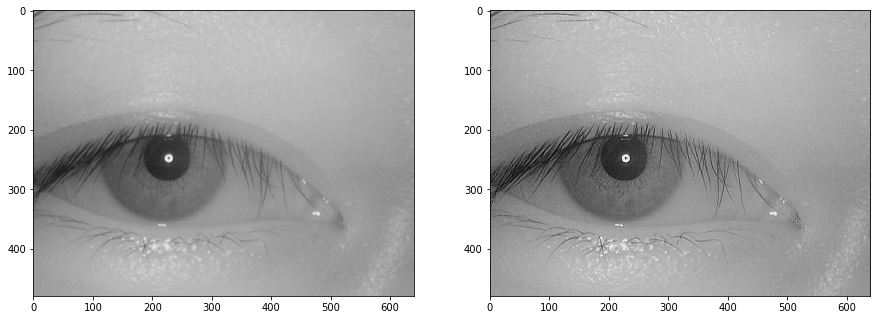

In [19]:
# Sharpening test
sharp_image = sharp_process('datasets/no_processing/0000/0000_001.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(sharp_image)

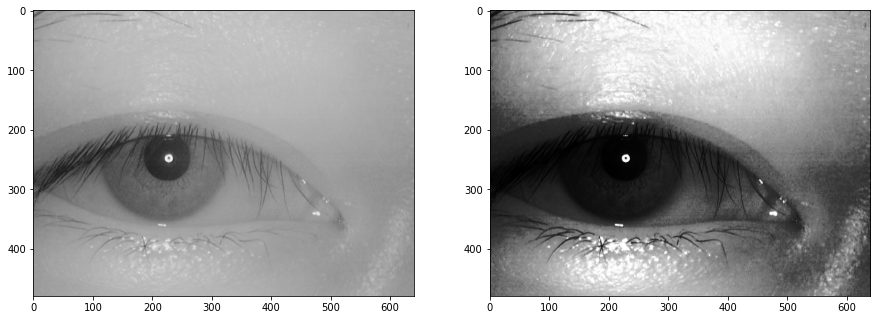

In [20]:
# Equalize histogram test

hist_eq_image = hist_eq_process('datasets/no_processing/0000/0000_001.bmp')

# Save and open image
cv2.imwrite('datasets/demo/hist_eq_image.bmp', hist_eq_image)
hist_eq_image = cv2.imread('datasets/demo/hist_eq_image.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(hist_eq_image)

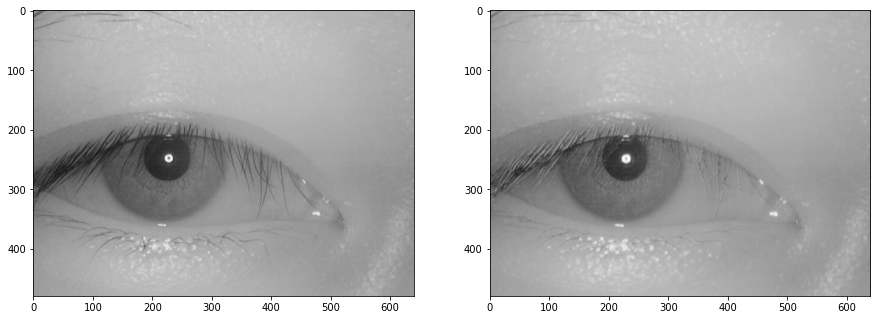

In [21]:
# Morph + blur test

# Morph
morph_image = morph_process('datasets/no_processing/0000/0000_001.bmp')

# Blur
morph_blur_3x3_image = cv2.GaussianBlur(morph_image,(3,3), sigmaX=0, sigmaY=0)

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(morph_blur_3x3_image)

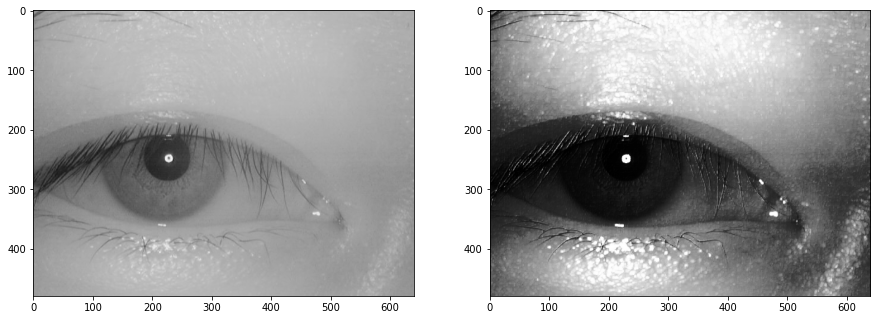

In [22]:
# Morph + equalize histogram test

# Morph
morph_image = morph_process('datasets/no_processing/0000/0000_001.bmp')

# Equalize histogram
morph_gray_image = cv2.cvtColor(morph_image, cv2.COLOR_BGR2GRAY)
morph_hist_eq_image = cv2.equalizeHist(morph_gray_image)

# Save and open image
cv2.imwrite('datasets/demo/morph_hist_eq_image.bmp', morph_hist_eq_image)
morph_hist_eq_image = cv2.imread('datasets/demo/morph_hist_eq_image.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(morph_hist_eq_image)

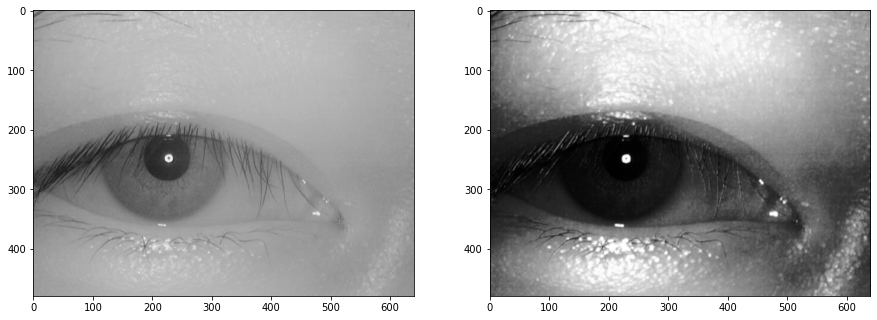

In [23]:
# Morph + equalize histogram + blur test

# Morph
morph_image = morph_process('datasets/no_processing/0000/0000_001.bmp')


# Equalize histogram
morph_gray_image = cv2.cvtColor(morph_image, cv2.COLOR_BGR2GRAY)
morph_hist_eq_image = cv2.equalizeHist(morph_gray_image)

# Blur
morph_hist_eq_blur_3x3_image = cv2.GaussianBlur(morph_hist_eq_image,(3,3), sigmaX=0, sigmaY=0)

# Save and open image
cv2.imwrite('datasets/demo/morph_hist_eq_blur_3x3_image.bmp', morph_hist_eq_blur_3x3_image)
morph_hist_eq_blur_3x3_image = cv2.imread('datasets/demo/morph_hist_eq_blur_3x3_image.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(morph_hist_eq_blur_3x3_image)

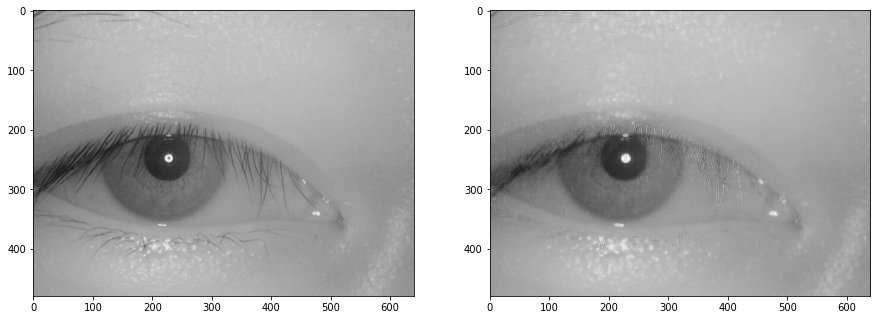

In [24]:
# Filter 2D test

contour_image = contour_process('datasets/no_processing/0000/0000_001.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(contour_image)

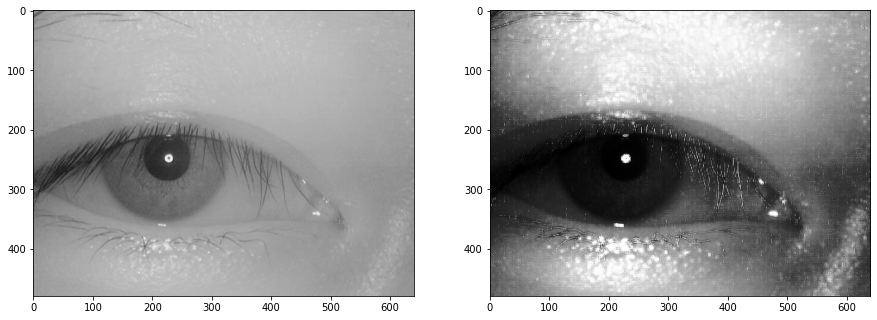

In [25]:
# Filter 2D + equalize histogram test

# Filter 2D
contour_image = contour_process('datasets/no_processing/0000/0000_001.bmp')

# Equalize histogram
contour_gray_image = cv2.cvtColor(contour_image, cv2.COLOR_BGR2GRAY)
contour_hist_eq_image = cv2.equalizeHist(contour_gray_image)

# Save and open image
cv2.imwrite('datasets/demo/contour_hist_eq_image.bmp', contour_hist_eq_image)
contour_hist_eq_image = cv2.imread('datasets/demo/contour_hist_eq_image.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(contour_hist_eq_image)

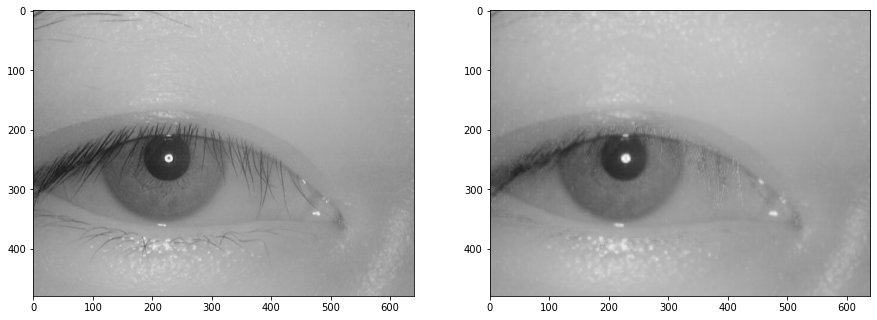

In [26]:
# Filter 2D test + blur test

# Filter 2D
contour_image = contour_process('datasets/no_processing/0000/0000_001.bmp')

# Blur
contour_blur_3x3_image = cv2.GaussianBlur(contour_image,(3,3), sigmaX=0, sigmaY=0)

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(contour_blur_3x3_image)

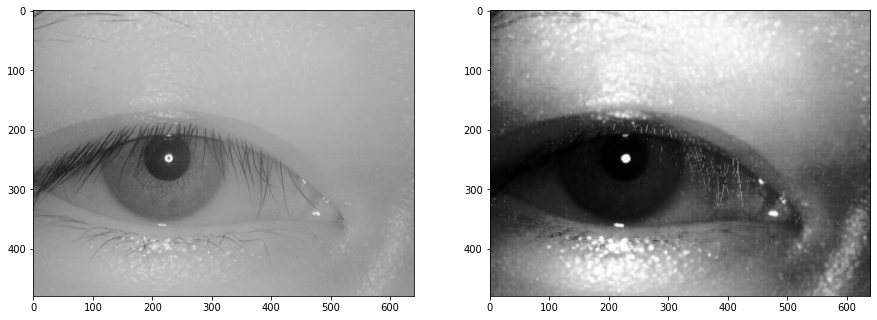

In [27]:
# Filter 2D + equalize histogram + blur test

# Filter 2D
contour_image = contour_process('datasets/no_processing/0000/0000_001.bmp')

# Equalize histogram
contour_gray_image = cv2.cvtColor(contour_image, cv2.COLOR_BGR2GRAY)
contour_hist_eq_image = cv2.equalizeHist(contour_gray_image)

# Blur
contour_hist_eq_blur_3x3_image = cv2.GaussianBlur(contour_hist_eq_image,(3,3), sigmaX=0, sigmaY=0)

# Save and open image
cv2.imwrite('datasets/demo/contour_hist_eq_blur_3x3_image.bmp', contour_hist_eq_blur_3x3_image)
contour_hist_eq_blur_3x3_image = cv2.imread('datasets/demo/contour_hist_eq_blur_3x3_image.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(contour_hist_eq_blur_3x3_image)

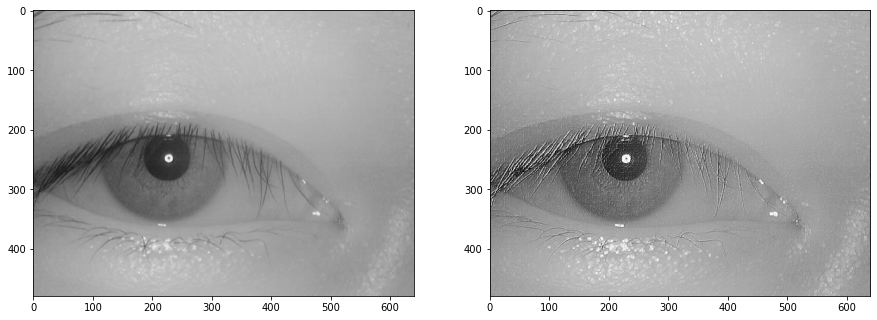

In [28]:
# Morph + sharpening test

# Morph
morph_image = morph_process('datasets/no_processing/0000/0000_001.bmp')

#  Sharpen
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
morph_sharp_image = cv2.filter2D(src=morph_image, ddepth=-1, kernel=kernel)

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(morph_sharp_image)


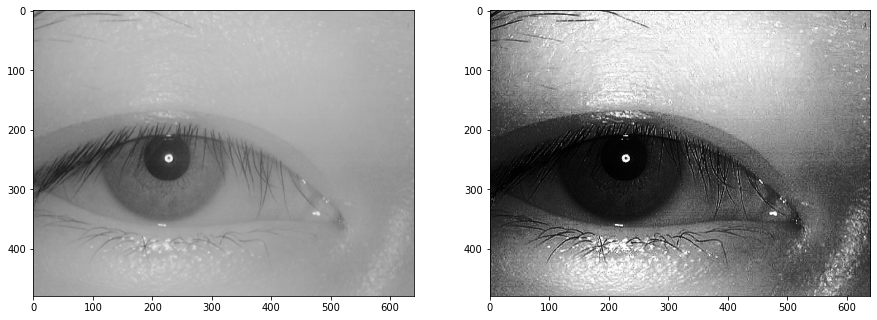

In [29]:
# Sharpening + equalize histogram test

# Sharpen
sharp_image = sharp_process('datasets/no_processing/0000/0000_001.bmp')

# Equalize histogram
sharp_gray_image = cv2.cvtColor(sharp_image, cv2.COLOR_BGR2GRAY)
sharp_hist_eq_image = cv2.equalizeHist(sharp_gray_image)

# Save and open image
cv2.imwrite('datasets/demo/sharp_hist_eq_image.bmp', sharp_hist_eq_image)
sharp_hist_eq_image = cv2.imread('datasets/demo/sharp_hist_eq_image.bmp')

f, axarr = plt.subplots(1,2,figsize=(15, 15))
axarr[0].imshow(image)
axarr[1].imshow(sharp_hist_eq_image)

In [30]:
# # Process all images with all pre-processing techniques

# # Single pre-processing
# process_images(morph_process, 'no_processing', 'morph')
# process_images(sobel_process, 'no_processing', 'sobel')
# process_images(blur_process, 'no_processing', 'blur_3x3')
# process_images(sharp_process, 'no_processing', 'sharp')
# process_images(hist_eq_process, 'no_processing', 'hist_eq')
# process_images(contour_process, 'no_processing', 'contour')

# # Double pre-processing
# process_images(blur_process, 'morph', 'morph_blur_3x3')
# process_images(hist_eq_process, 'morph', 'morph_eq')
# process_images(hist_eq_process, 'contour', 'contour_eq')
# process_images(blur_process, 'contour', 'contour_blur_3x3')
# process_images(sharp_process, 'morph', 'morph_sharp')
# process_images(hist_eq_process, 'sharp', 'sharp_hist_eq')


# # Triple pre-processing
# process_images(blur_process, 'morph_eq', 'morph_eq_blur_3x3')
# process_images(blur_process, 'contour_eq', 'contour_eq_blur_3x3')


In [31]:
# Train models using pre-processed images

# train_model('no_processing')
# train_model('morph')
# train_model('sobel')
# train_model('blur_3x3')
# train_model('sharp')
# train_model('hist_eq')
# train_model('contour')

# train_model('morph_blur_3x3')
# train_model('morph_eq')
# train_model('contour_eq')
# train_model('contour_blur_3x3')
# train_model('morph_sharp')
# train_model('sharp_hist_eq')

# train_model('morph_eq_blur_3x3')
# train_model('contour_eq_blur_3x3')


In [32]:
# Clean datasets based on images that failed training

# clean_dataset('no_processing')
# clean_dataset('morph')
# clean_dataset('sobel')
# clean_dataset('blur_3x3')
# clean_dataset('sharp')
# clean_dataset('hist_eq')
# clean_dataset('contour')

# clean_dataset('morph_blur_3x3')
# clean_dataset('morph_eq')
# clean_dataset('contour_eq')
# clean_dataset('contour_blur_3x3')
# clean_dataset('morph_sharp')
# clean_dataset('sharp_hist_eq')

# clean_dataset('morph_eq_blur_3x3')
# clean_dataset('contour_eq_blur_3x3')

In [33]:
# Train new models using clean datasets

# train_model('no_processing_clean')
# train_model('morph_clean')
# train_model('sobel_clean')
# train_model('blur_3x3_clean')
# train_model('sharp_clean')
# train_model('hist_eq_clean')
# train_model('contour_clean')

# train_model('morph_blur_3x3_clean')
# train_model('morph_eq_clean')
# train_model('contour_eq_clean')
# train_model('contour_blur_3x3_clean')
# train_model('morph_sharp_clean')
# train_model('sharp_hist_eq_clean')

# train_model('morph_eq_blur_3x3_clean')
# train_model('contour_eq_blur_3x3_clean')

In [34]:
# test_images('no_processing')

# # Os comentados foram omitidos pois não houveram "pessoas" que passaram no treinamento

# # test_images('morph')
# # test_images('sobel')
# test_images('blur_3x3')
# test_images('sharp')
# test_images('hist_eq')
# test_images('contour')

# test_images('morph_blur_3x3')
# test_images('morph_eq')
# # test_images('contour_eq')
# test_images('contour_blur_3x3')
# test_images('morph_sharp')
# test_images('sharp_hist_eq')



# test_images('morph_eq_blur_3x3')
# test_images('contour_eq_blur_3x3')

Processing type: no_processing
Total tested images: 1163
Total matched images: 460 ( 39.55288048151333 %)
Total correct images: 43
Total false positives: 417 


Processing type: blur_3x3
Total tested images: 1163
Total matched images: 464 ( 39.896818572656926 %)
Total correct images: 46
Total false positives: 418 


Processing type: sharp
Total tested images: 1163
Total matched images: 351 ( 30.180567497850387 %)
Total correct images: 47
Total false positives: 304 


Processing type: hist_eq
Total tested images: 1163
Total matched images: 536 ( 46.087704213241615 %)
Total correct images: 42
Total false positives: 494 


Processing type: contour
Total tested images: 1163
Total matched images: 404 ( 34.73774720550301 %)
Total correct images: 34
Total false positives: 370 


Processing type: morph_blur_3x3
Total tested images: 1163
Total matched images: 324 ( 27.858985382631126 %)
Total correct images: 19
Total false positives: 305 


Processing type: morph_eq
Total tested images: 1163
To

In [ ]:
# Testing models using clean datasets

test_images('no_processing_clean')

# Os comentados foram omitidos pois não houveram "pessoas" que passaram no treinamento

# test_images('morph')
# test_images('sobel')
test_images('blur_3x3_clean')
test_images('sharp_clean')
test_images('hist_eq_clean')
test_images('contour_clean')

test_images('morph_blur_3x3_clean')
test_images('morph_eq_clean')
# test_images('contour_eq')
test_images('contour_blur_3x3_clean')
test_images('morph_sharp_clean')
test_images('sharp_hist_eq_clean')



test_images('morph_eq_blur_3x3_clean')
test_images('contour_eq_blur_3x3_clean')

Processing type: no_processing
Total tested images: 415
Total matched images: 415 ( 100.0 % )
Total correct images: 43
Total false positives: 372 


Processing type: blur_3x3
Total tested images: 425
Total matched images: 425 ( 100.0 % )
Total correct images: 46
Total false positives: 379 


Processing type: sharp
Total tested images: 298
Total matched images: 298 ( 100.0 % )
Total correct images: 47
Total false positives: 251 


Processing type: hist_eq
Total tested images: 499
Total matched images: 499 ( 100.0 % )
Total correct images: 42
Total false positives: 457 


Processing type: contour
Total tested images: 357
Total matched images: 357 ( 100.0 % )
Total correct images: 34
Total false positives: 323 


Processing type: morph_blur_3x3
Total tested images: 285
Total matched images: 285 ( 100.0 % )
Total correct images: 19
Total false positives: 266 




## Resultados dos treinamentos:
Foram treinados modelos para todos os tipos de pré processamento mencionados no início.

Após um treinamento inicial, foram avaliadas quais imagens eram boas o suficiente para o modelo, assim, foram descartadas todas as imagens "ruins" e imagens de pessoas que possuiam menos de 5 imagens boas (de acordo com a documentação do G6, pelo menos 5 imagens são necessárias por pessoa para ter um modelo minimamente bom). Assim são criados novos datasets, apenas com imagens e pessoas "boas" para treinamento

Após a criação dos datasets "bons", é feito um novo treinamento, para a criação de novos modelos, sendo treinados apenas com as imagens boas.


### Total de imagens do dataset: 1163


## Sem pré processamento
- Imagens aceitas: 415
- Pessoas aceitas: 29


## 1 pré processamento

- Processamento morfológico:
  - Imagens aceitas: 240
  - Pessoas aceitas: 19


- Filtro Sobel:
  - Imagens aceitas: 0
  - Pessoas aceitas:0


- Blur com kernel 3x3:
  - Imagens aceitas: 425
  - Pessoas aceitas: 31


- Sharpening:
  - Imagens aceitas: 298
  - Pessoas aceitas: 25


- Equalização de histograma:
  - Imagens aceitas: 499
  - Pessoas aceitas: 41


- Filtro 2D:
  - Imagens aceitas: 357
  - Pessoas aceitas: 27


## 2 pré processamentos
- Processamento morfológico + Blur:
  - Imagens aceitas: 285
  - Pessoas aceitas: 23


- Processamento morfológico + Equalização de histograma:
  - Imagens aceitas: 459
  - Pessoas aceitas: 42


- Filtro 2D + Equalização de histograma:
  - Imagens aceitas: 514
  - Pessoas aceitas: 45


- Filtro 2D + Blur:
  - Imagens aceitas: 610
  - Pessoas aceitas: 31

- Processamento morfológico + Sharpening:
  - Imagens aceitas: 2
  - Pessoas aceitas: 10


- Sharpening + Equalização de histograma:
  - Imagens aceitas: 442
  - Pessoas aceitas: 38


## 3 pré processamentos

- Processamento morfológico + Equalização de histograma + Blur:
  - Imagens aceitas: 575
  - Pessoas aceitas: 47

- Filtro 2D + Equalização de histograma + Blur:
  - Imagens aceitas: 530
  - Pessoas aceitas: 44


#### Procesasmento que mais aprovou imagens: Filtro 2D + Blur (610)
#### Processamento que mais aprovou pessoas: Processamento morfológico + Equalização de histograma + Blur (47)

## Resultados dos testes:
Para os testes, foram usados os modelos treinados apenas com as imagens avaliadas como "boas".
Foram testadas todas as imagens, sendo aplicados os processamentos respectivos aos aplicados durante os treinamentos dos modelos

### Total de imagens testadas: 1163


## Sem pré processamento
  - Total matched images: 460 ( 39.55288048151333 %)
  - Total correct images: 43
  - Total false positives: 417

## 1 pré processamento
- Processing type: blur_3x3
  - Total matched images: 464 ( 39.896818572656926 %)
  - Total correct images: 46
  - Total false positives: 418


- Processing type: sharp
  - Total matched images: 351 ( 30.180567497850387 %)
  - Total correct images: 47
  - Total false positives: 304


- Processing type: hist_eq
  - Total matched images: 536 ( 46.087704213241615 %)
  - Total correct images: 42
  - Total false positives: 494


- Processing type: contour
  - Total matched images: 404 ( 34.73774720550301 %)
  - Total correct images: 34
  - Total false positives: 370


## 2 pré processamentos
- Processing type: morph_blur_3x3
  - Total matched images: 324 ( 27.858985382631126 %)
  - Total correct images: 19
  - Total false positives: 305


- Processing type: morph_eq
  - Total matched images: 493 ( 42.39036973344798 %)
  - Total correct images: 35
  - Total false positives: 458


- Processing type: contour_blur_3x3
  - Total matched images: 455 ( 39.122957867583835 %)
  - Total correct images: 32
  - Total false positives: 423


- Processing type: morph_sharp
  - Total matched images: 25 ( 2.1496130696474633 %)
  - Total correct images: 10
  - Total false positives: 15 


- Processing type: sharp_hist_eq
  - Total matched images: 479 ( 41.1865864144454 %)
  - Total correct images: 57
  - Total false positives: 422 


## 3 pré processamentos
- Processing type: morph_eq_blur_3x3
  - Total matched images: 596 ( 51.24677558039553 %)
  - Total correct images: 21
  - Total false positives: 575


- Processing type: contour_eq_blur_3x3
  - Total matched images: 550 ( 47.2914875322442 %)
  - Total correct images: 37
  - Total false positives: 513


#### Processamento que mais obteve match: Processamento morfológico + Equalização de histograma + Blur (596 [51.2%])
#### Processamento que mais obteve verdadeiros positivos: Sharpening + Equalização de histograma (57 [4.9%])

## Testes futuros

Observando os treinos e testes, percebe-se que alguns tipo de processamentos melhoram a qualidade do treinamento do modelo, porém quando realizam-se os testes, o mesmo tipo de processamento com o respectivo modelo, não apresentam uma boa taxa de verdadeiros positivos.

Com isso em mente, seria interessante realizar o treinamento com as imagens que mais foram aceitas para treino porém realizar a predição de íris utilizando imagens com um tipo de processamento diferente do usado para treino, por exemplo, treinar utilizando o processamento morfológico + equalização de histograma + blur e nos testes, utilizar as imagens com o sharpening aplicado.

Abaixo é feito o teste mencionado acima.

In [227]:
process_name = 'morph_eq_blur_3x3'
dataset_name = 'sharp_hist_eq'

total_imgs = 0
correct_imgs = 0
positive_imgs = 0
false_positives = 0

# Disable prints to avoid flooding
with HiddenPrints():
    imgs_dir = os.getcwd() + '/datasets/' + dataset_name
    for subdir in os.listdir(imgs_dir):
        full_subdir = imgs_dir + '/' + subdir
        for filename in os.listdir(full_subdir):
            if filename.endswith(".bmp"):
                image_name = os.path.join(full_subdir, filename).split('/', 7)[-1]
                # print(image_name)
                person_name = image_name.split('/')[-2]
                result = G6_iris_recognition.iris_model_test('models/' + process_name + '_clean.pickle', image_name)
                if (not result == 'unmatch'):
                    positive_imgs += 1
                    if (person_name == result):
                        correct_imgs += 1
                    else:
                        false_positives += 1
                total_imgs += 1
                # print('result:', result)
# Restore prints
print('Model used:', process_name)
print('Dataset for tests:', dataset_name)
print('Total tested images:', total_imgs)
print('Total matched images:', positive_imgs, '(', positive_imgs/total_imgs * 100, '%)')
print('Total correct images:', correct_imgs)
print('Total false positives:', false_positives, '\n\n')

Model used: morph_eq_blur_3x3
Dataset for tests: sharp_hist_eq
Total tested images: 1163
Total matched images: 479 ( 41.1865864144454 %)
Total correct images: 3
Total false positives: 476 


